In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Load

In [0]:
import pandas as pd
import numpy as np
from collections import defaultdict
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score

from tqdm import tqdm

# model
import lightgbm as lgb

SEED=42
LABEL=None

In [10]:
import os
os.getcwd()

'/content'

In [11]:
# train
# path = 'drive/My Drive/bigcontest2019/data/'
path = '/drive/My Drive/bigcontest2019/'
train_activity = pd.read_csv(path + 'data/train/train_activity.csv').drop(columns='fishing')
# train_payment = pd.read_csv(path + 'data/train/train_payment.csv')
# train_trade = pd.read_csv(path + 'data/train/train_trade.csv')
# train_pledge = pd.read_csv(path + 'data/train/train_pledge.csv').drop(columns=['combat_play_time', 'non_combat_play_time'])
# train_combat = pd.read_csv(path + 'data/train/train_combat.csv')

# test1_activity = pd.read_csv(path+'data/test/test1_activity.csv').drop(columns='fishing')
# test1_combat = pd.read_csv(path+'data/test/test1_combat.csv')
# test1_payment = pd.read_csv(path+'data/test/test1_payment.csv')
# test1_pledge = pd.read_csv(path+'data/test/test1_pledge.csv').drop(columns=['combat_play_time', 'non_combat_play_time'])
# test1_trade = pd.read_csv(path+'data/test/test1_trade.csv')

# test2_activity = pd.read_csv(path + 'data/test/test2_activity.csv').drop(columns='fishing')
# test2_combat = pd.read_csv(path + 'data/test/test2_combat.csv')
# test2_payment = pd.read_csv(path + 'data/test/test2_payment.csv')
# test2_pledge = pd.read_csv(path + 'data/test/test2_pledge.csv').drop(columns=['combat_play_time', 'non_combat_play_time'])
# test2_trade = pd.read_csv(path + 'data/test/test2_trade.csv')

# train_label = pd.read_csv(path+'data/train/train_label.csv')

FileNotFoundError: ignored

In [0]:
activity_all_df = pd.concat([pd.concat([train_activity,test1_activity]),test2_activity])
combat_all_df = pd.concat([pd.concat([train_combat,test1_combat]),test2_combat])
trade_all_df = pd.concat([pd.concat([train_trade,test1_trade]),test2_trade])
pledge_all_df = pd.concat([pd.concat([train_pledge,test1_pledge]),test2_pledge])
payment_all_df = pd.concat([pd.concat([train_payment,test1_payment]),test2_payment])

# User2vec

In [0]:
class User2Vec(object):
    def __init__(self, data):
        self.data = data
        self.groupby_dict = defaultdict()
        self.groupby_dict2 = defaultdict()
        self.group_df = pd.DataFrame()
        self.similiraty_dict = defaultdict(list)
        self.user2vec_df = pd.DataFrame()

    def activity_dict(self):        

        temp_df = pd.get_dummies(self.data)
        temp_df['game_money_change'] = np.abs(temp_df['game_money_change'])

        for feature in temp_df.columns:
            if feature == 'acc_id' or feature == 'day':
                pass
            elif feature == 'char_id':
                self.groupby_dict[feature] = 'nunique'
            else:
                self.groupby_dict[feature] = 'sum'
        else:
            self.group_df = temp_df.groupby(['acc_id','day']).agg(self.groupby_dict).reset_index()
    
        return self.group_df, self.groupby_dict

    def payment_dict(self):
        for feature in self.data.columns:   
            if feature == 'acc_id' or feature == 'day':
                pass
            else:
                self.groupby_dict[feature] = ['sum', 'count', 'max', 'std']
        else:
            self.group_df = self.data.groupby(['acc_id','day']).agg(self.groupby_dict).reset_index()
            self.group_df.columns = [i+j for i,j in self.group_df.columns.ravel()]

        return self.group_df, self.groupby_dict

    def trade_dict(self):
        output_df = self.data
        
        output_df['time'] = output_df['time'].apply(lambda x: str(x)[:2])
        output_df[['time', 'type', 'server']] = output_df[['time', 'type', 'server']].astype(object)
        output_df = pd.get_dummies(output_df)
        output_df2 = output_df.copy()
        
        output_df = output_df.rename(columns={'source_acc_id':'acc_id'})
        output_df2 = output_df2.rename(columns={'target_acc_id':'acc_id'})

        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'day':
                pass
            elif feature in [ 'item_type', 'source_char_id', 'target_char_id', 'target_acc_id']:
                self.groupby_dict[feature] = 'nunique'
            else:
                self.groupby_dict[feature] = 'sum'
        else:
            output_df = output_df.groupby(['acc_id', 'day']).agg(self.groupby_dict).reset_index()
        
        for feature in output_df2.columns:
            if feature == 'acc_id' or feature == 'day':
                pass
            elif feature in [ 'item_type', 'source_char_id', 'target_char_id', 'source_acc_id']:
                self.groupby_dict2[feature] = 'nunique'
            else:
                self.groupby_dict2[feature] = 'sum'
        else:
            output_df2 = output_df2.groupby(['acc_id', 'day']).agg(self.groupby_dict2).reset_index()
        self.group_df = pd.merge(output_df, output_df2, how='outer', on=['acc_id', 'day'])
        return self.group_df, self.groupby_dict, self.groupby_dict2

    def combat_dict(self):
        self.data[['server', 'class', 'level']] = self.data[['server', 'class', 'level']].astype(str)
        temp_df = pd.get_dummies(self.data)

        for feature in temp_df.columns:
            if feature == 'acc_id' or feature == 'day':
                pass
            elif feature == 'char_id':
                self.groupby_dict[feature] = ['nunique', 'size']
            else:
                self.groupby_dict[feature] = 'sum'
        else:
            self.group_df = temp_df.groupby(['acc_id', 'day']).agg(self.groupby_dict).reset_index()
            self.group_df.columns = [i+j for i,j in self.data.columns.ravel()]
        return self.group_df, self.groupby_dict

    def pledge_dict(self):        
        self.data[['server']] = self.data[['server']].astype(str)
        temp_df = pd.get_dummies(self.data)

        for feature in temp_df.columns:
            if feature == 'acc_id' or feature == 'day':
                pass
            elif feature == 'pledge_id':
                self.groupby_dict[feature] = 'nunique'
            elif feature == 'char_id':
                self.groupby_dict[feature] = ['nunique', 'size']
            else:
                self.groupby_dict[feature] = 'sum'
        else:
           self.group_df  = temp_df.groupby(['acc_id', 'day']).agg(self.groupby_dict).reset_index()
           self.group_df.columns= [i+j for i,j in self.group_df.columns.ravel()]
        return self.group_df, self.groupby_dict

    def pivoting(self):
        ind = list(self.group_df.columns)[0]
        col = list(self.group_df.columns)[1]
        names = list(self.group_df.columns)[2:]

        print('\n =========== {} iter ==========='.format(len(names)))

        for i, name in tqdm(enumerate(names)):
            tmp = self.group_df.pivot(index = ind, columns= col,values=name).fillna(0)
            tmp.columns = [name+'_day'+str(x) for x in tmp.columns]

            sim = []
            idx_lst = []

            for idx, acc_id in enumerate(tmp.index):
                idx_lst.append(acc_id)
                sim.append(np.round(tmp.iloc[idx,:].values,2).astype(str).tolist())

            documents = [TaggedDocument('acc_id_'+str(idx_lst[i]),doc) for i,doc in enumerate(sim)]
            model = Doc2Vec(documents, vector_size=VECTOR, window=WINDOW, min_count=MINCOUNT, workers=-1)

            similiraty_dict = defaultdict(list)

            for i in idx_lst:
                similiraty_dict[i]= model.infer_vector('acc_id_'+str(i)).tolist()

            temp_user2vec = pd.DataFrame(similiraty_dict).transpose()
            temp_user2vec.columns=['{0}_infer_vec_{1}'.format(name,i+1) for i in range(len(temp_user2vec.columns))]
        
            self.user2vec_df = pd.concat([self.user2vec_df,temp_user2vec],axis=1)
            self.user2vec_df.reset_index().rename({'index':'acc_id'})

        output = self.user2vec_df.copy()
        return output

In [0]:
VECTOR = 10
WINDOW = 7
MINCOUNT = 20

In [0]:
transform = User2Vec(train_payment)
transform.payment_dict()
payment_u2v = transform.pivoting()

In [0]:
payment_u2v.rename(columns = {'index':'acc_id'}).reset_index(inplace=True)
payment_u2v.head()

In [0]:
train_label.loc[train_label['survival_time']!=64,'state'] = 'churn'
train_label.loc[train_label['survival_time']==64,'state'] = 'survive'

In [0]:
payment_u2v.reset_index(inplace=True)
payment_u2v.rename(columns={'index':'acc_id'},inplace=True)
u2v_label = pd.merge(payment_u2v,train_label[['acc_id','state']],how='left', on='acc_id')

In [0]:
pca = PCA(n_components=2)
pca_output = pca.fit_transform(payment_u2v)

In [0]:
pca_output

array([[ 6.65326478e+04,  9.03458554e+01],
       [ 6.65206634e+04,  8.91740122e+01],
       [ 6.65195000e+04,  8.99781094e+01],
       ...,
       [-6.60676678e+04, -7.47265419e+00],
       [-6.60688311e+04, -6.66854710e+00],
       [-6.60719620e+04, -6.22371126e+00]])

In [0]:
final_df = pd.concat([pd.DataFrame(pca_output),u2v_label['state']],axis=1)
final_df.columns = ['Component_1','Component_2','state']

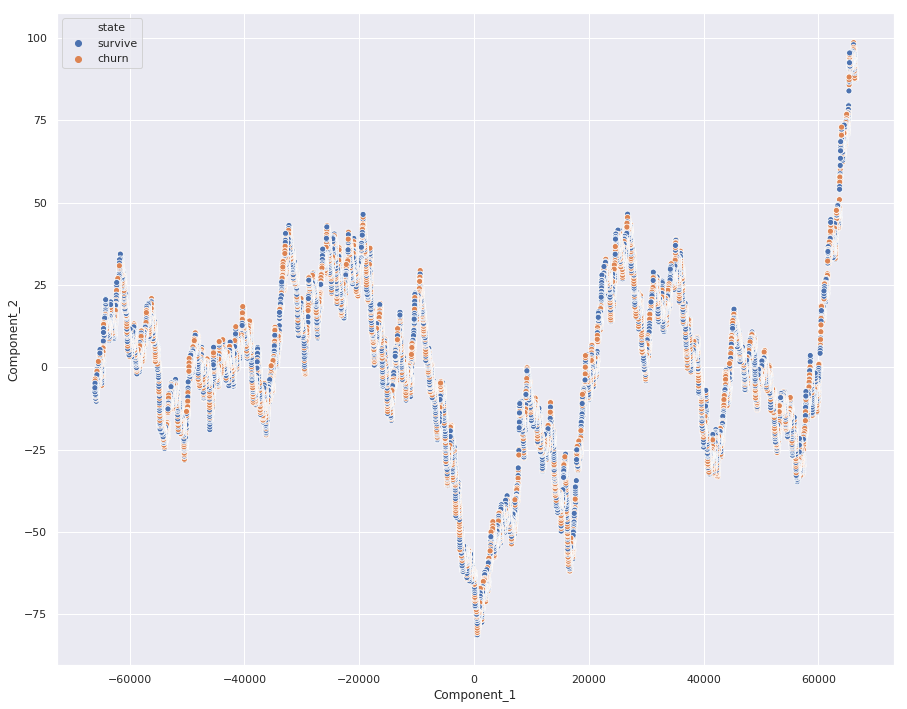

In [0]:
sns.set(rc={'figure.figsize':(15,12)})
sns.scatterplot(x='Component_1',y='Component_2',data=final_df,hue='state')

# Visualize

In [0]:
VECTOR = 10
WINDOW = 7
MINCOUNT = 20

In [0]:
transform = User2Vec(train_trade)
transform.trade_dict()
trade_u2v = transform.pivoting()

In [0]:
transform

In [0]:
activity_u2v.reset_index(inplace=True)
activity_u2v.rename(columns={'index':'acc_id'},inplace=True)
u2v_label = pd.merge(activity_u2v,train_label[['acc_id','state']],how='left', on='acc_id')

In [0]:
pca = PCA(n_components=2)
pca_act_output = pca.fit_transform(activity_u2v)

In [0]:
pca_act_output

array([[ 6.52791056e+04,  3.07818120e-02],
       [ 6.52761055e+04, -4.14049980e-02],
       [ 6.52731055e+04,  1.76881378e-01],
       ...,
       [-6.51878944e+04,  2.53895864e-01],
       [-6.51888945e+04,  2.38895829e-01],
       [-6.51918944e+04, -4.70338238e-02]])

In [0]:
final_df = pd.concat([pd.DataFrame(pca_act_output),u2v_label['state']],axis=1)
final_df.columns = ['Component_1','Component_2','state']

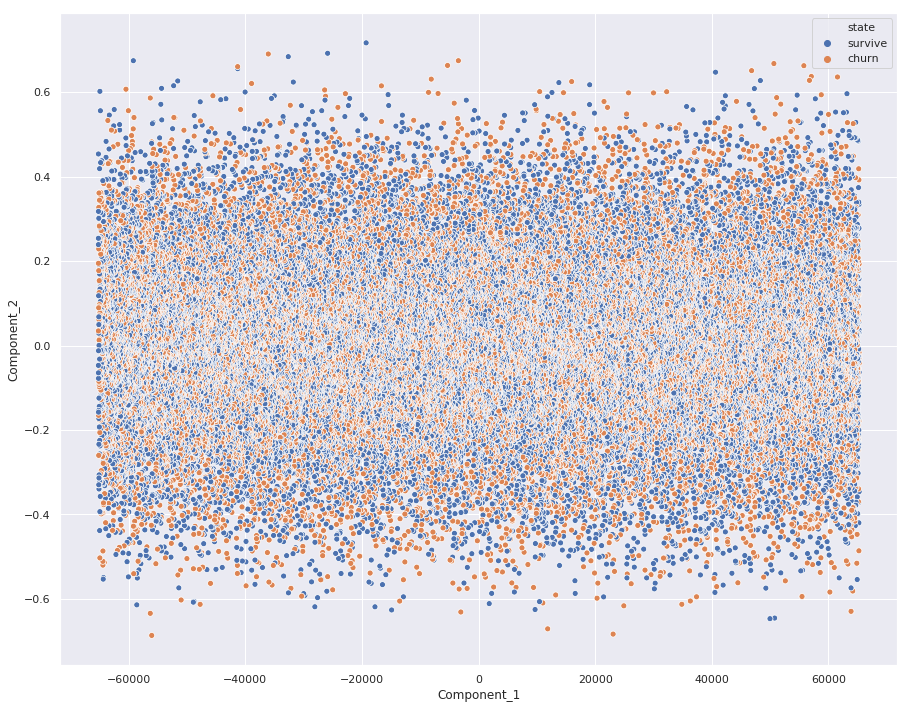

In [0]:
sns.set(rc={'figure.figsize':(15,12)})
sns.scatterplot(x='Component_1',y='Component_2',data=final_df,hue='state')

In [0]:
import joblib

fis = joblib.load("/content/drive/My Drive/bigcontest2019/scripts/hh's work/feature_importance/feature_importance.ckpt")
# fis = fis['Feature'].tolist()
# fis.extend(['acc_id', 'week'])

In [0]:
feature_import = ['server','exp_recovery','item_amount','level','server_az','temp_cnt','item_type','playtime']

In [0]:
train_activity.columns

Index(['day', 'acc_id', 'char_id', 'server', 'playtime', 'npc_kill',
       'solo_exp', 'party_exp', 'quest_exp', 'rich_monster', 'death', 'revive',
       'exp_recovery', 'private_shop', 'game_money_change', 'enchant_count'],
      dtype='object')

In [0]:
group_df  = train_activity.groupby(['acc_id', 'day']).agg({'':'sum'}).reset_index()

In [0]:
tmp = group_df.pivot(index = 'acc_id', columns= 'day',values='solo_exp').fillna(0).reset_index()
tt = pd.merge(tmp,train_label[['acc_id','state']],how='left', on='acc_id')

In [0]:
u2v_label = 

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_act_output = pd.DataFrame(pca.fit_transform(tmp))
final_df = pd.concat([train_label[['acc_id','state']],pd.DataFrame(pca_act_output)],axis=1)
final_df.columns = ['acc_id','state','Component_1','Component_2']

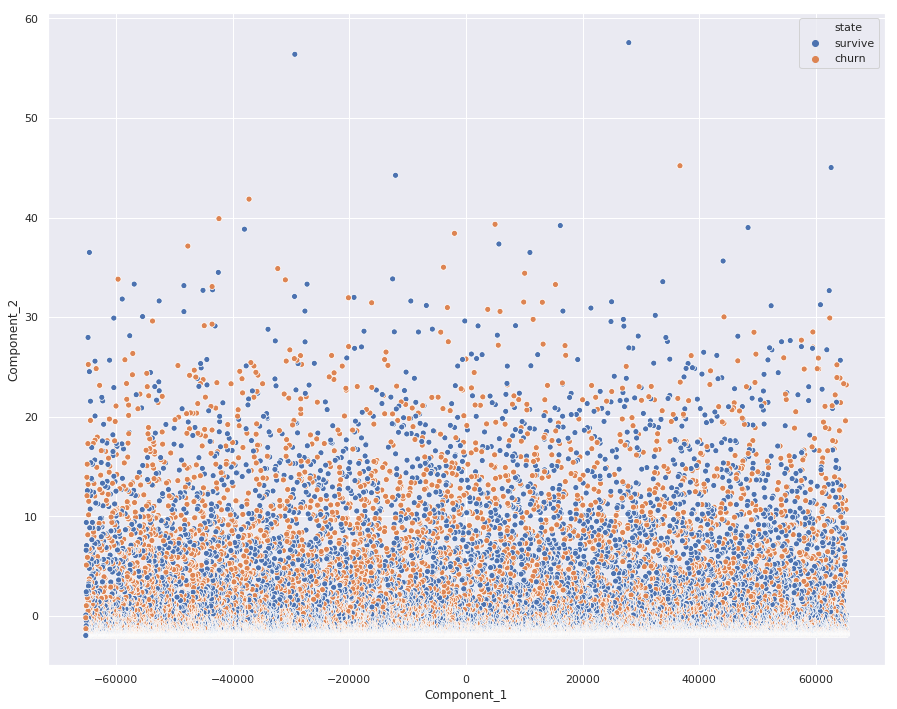

In [0]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,12)})
sns.scatterplot(x='Component_1',y='Component_2',data=final_df,hue='state')

In [0]:
def pivoting(self):
    ind = list(self.group_df.columns)[0]
    col = list(self.group_df.columns)[1]
    names = list(self.group_df.columns)[2:]

    print('\n =========== {} iter ==========='.format(len(names)))

    for i, name in tqdm(enumerate(names)):
        tmp = self.group_df.pivot(index = ind, columns= col,values=name).fillna(0)
        tmp.columns = [name+'_day'+str(x) for x in tmp.columns]

        sim = []
        idx_lst = []

        for idx, acc_id in enumerate(tmp.index):
            idx_lst.append(acc_id)
            sim.append(np.round(tmp.iloc[idx,:].values,2).astype(str).tolist())

        documents = [TaggedDocument('acc_id_'+str(idx_lst[i]),doc) for i,doc in enumerate(sim)]
        model = Doc2Vec(documents, vector_size=VECTOR, window=WINDOW, min_count=MINCOUNT, workers=-1)

        similiraty_dict = defaultdict(list)

        for i in idx_lst:
            similiraty_dict[i]= model.infer_vector('acc_id_'+str(i)).tolist()

        temp_user2vec = pd.DataFrame(similiraty_dict).transpose()
        temp_user2vec.columns=['{0}_infer_vec_{1}'.format(name,i+1) for i in range(len(temp_user2vec.columns))]
    
        self.user2vec_df = pd.concat([self.user2vec_df,temp_user2vec],axis=1)
        self.user2vec_df.reset_index().rename({'index':'acc_id'})

    output = self.user2vec_df.copy()
    return output